In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Conv2D, GlobalAveragePooling2D


In [3]:
IMG_SAVE_PATH = '/content/drive/MyDrive/train'


In [4]:
Str_to_Int = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma':5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis':7,
    'Vascular lesion': 8
}

NUM_CLASSES = 9


def str_to_Int_mapper(val):
    return Str_to_Int[val]

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2

dataset = []
for directory in os.listdir(IMG_SAVE_PATH):
    path = os.path.join(IMG_SAVE_PATH, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        try:
            imgpath = Image.open(new_path)
            imgpath = imgpath.convert('RGB')                 # Ensure 3 channels
            img = np.asarray(imgpath)
            img = cv2.resize(img, (240, 240))                # Resize to 240x240
            img = img / 255.0                                # Normalize
            dataset.append([img, directory])                 # Append to dataset
        except FileNotFoundError:
            print(f'File not found: {new_path}')
        except Exception as e:
            print(f"Error processing {new_path}: {e}")


In [ ]:
data, labels = zip(*dataset)
temp = list(map(str_to_Int_mapper, labels))

In [7]:
import keras
labels = keras.utils.to_categorical(temp)

In [8]:
count=0
for i in data:
    if i.shape!=(240, 240, 3):
        count=count+1
print(count)

0


In [9]:
# @title DenseNet
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

def build_densenet():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(9, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model = build_densenet()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,046,729 (26.88 MB)

 Trainable params: 6,963,081 (26.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [11]:
history=model.fit(np.array(data), np.array(labels), epochs = 5, shuffle = True, validation_split = 0.2)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 727s 34s/step - accuracy: 0.1898 - loss: 2.5822 - val_accuracy: 0.1286 - val_loss: 2.8613
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 601s 33s/step - accuracy: 0.5859 - loss: 1.2809 - val_accuracy: 0.1429 - val_loss: 2.9688
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 616s 33s/step - accuracy: 0.7266 - loss: 0.8132 - val_accuracy: 0.1143 - val_loss: 3.0407
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 622s 33s/step - accuracy: 0.8545 - loss: 0.5125 - val_accuracy: 0.0643 - val_loss: 3.1349
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 618s 32s/step - accuracy: 0.8631 - loss: 0.4574 - val_accuracy: 0.0643 - val_loss: 3.1999


Save till this marker line

In [12]:
#marker number 1, save data to current position
import os
import pickle
import json
import numpy as np

# Save directory
save_dir = '/content/drive/MyDrive/final_project/marker1'
os.makedirs(save_dir, exist_ok=True)

# Save model
model.save(os.path.join(save_dir, 'model.keras'))

# Save training history
with open(os.path.join(save_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# Save dataset
np.save(os.path.join(save_dir, 'data.npy'), np.array(data))
np.save(os.path.join(save_dir, 'labels.npy'), np.array(labels))

# Save label mapping
with open(os.path.join(save_dir, 'label_map.json'), 'w') as f:
    json.dump(Str_to_Int, f)


LOAD THE MARKER

In [13]:

import os
import pickle
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load directory
load_dir = '/content/drive/MyDrive/final_project/marker1'

# Load model
model = load_model(os.path.join(load_dir, 'model.keras'))

# Load training history
with open(os.path.join(load_dir, 'history.pkl'), 'rb') as f:
    history = pickle.load(f)

# Load dataset
data = np.load(os.path.join(load_dir, 'data.npy'))
labels = np.load(os.path.join(load_dir, 'labels.npy'))

# Load label mapping
with open(os.path.join(load_dir, 'label_map.json'), 'r') as f:
    Str_to_Int = json.load(f)


In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_acc(history_dict):
    sns.set()
    fig = plt.figure(0, (12, 4))

    # Plot Accuracy
    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=range(len(history_dict['accuracy'])), y=history_dict['accuracy'], label='train')
    sns.lineplot(x=range(len(history_dict['val_accuracy'])), y=history_dict['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    # Plot Loss
    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=range(len(history_dict['loss'])), y=history_dict['loss'], label='train')
    sns.lineplot(x=range(len(history_dict['val_loss'])), y=history_dict['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()


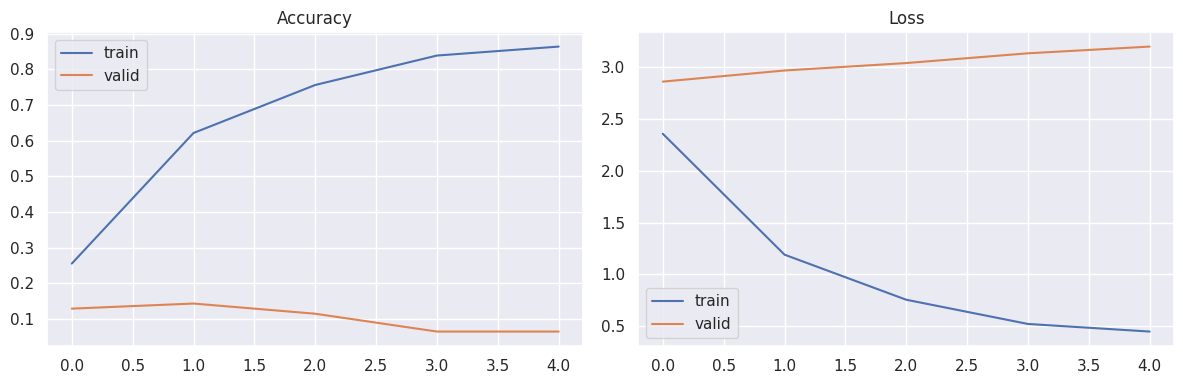

In [15]:
plot_acc(history)

# Mobile Net

In [16]:
def mobilenet():
    model = Sequential([
        tf.keras.applications.mobilenet.MobileNet(input_shape=(240,240, 3), include_top=False),
        Dropout(0.5),
        Convolution2D(9, (1, 1), padding='valid'),
        Activation('relu'),        # Rectified Linear Unit - Activation Function
        GlobalAveragePooling2D(),  # Pooling Layer
        Activation('softmax')      # Softmax - Activation Function - For Multi Class Classification
    ])
    return model

In [17]:
from keras.layers import Convolution2D, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [18]:
# define the model
model_mobile = mobilenet()
model_mobile.compile(
    optimizer=Adam(learning_rate=0.0001),         # lr = learning_rate
    loss='categorical_crossentropy',   # Multi-class classification
    metrics=['accuracy']
)

/tmp/ipython-input-16-630773363.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tf.keras.applications.mobilenet.MobileNet(input_shape=(240,240, 3), include_top=False),


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
model_mobile.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 9)        │         9,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 9)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 9)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,238,089 (12.35 MB)

 Trainable params: 3,216,201 (12.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [20]:
history_mobile=model_mobile.fit(np.array(data), np.array(labels), epochs = 5, shuffle = True, validation_split = 0.3)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.3151 - loss: 2.0094 - val_accuracy: 0.0000e+00 - val_loss: 4.1943
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 152s 9s/step - accuracy: 0.8070 - loss: 0.6994 - val_accuracy: 0.0000e+00 - val_loss: 4.3730
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.9525 - loss: 0.2727 - val_accuracy: 0.0000e+00 - val_loss: 4.1961
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 9s/step - accuracy: 0.9899 - loss: 0.1277 - val_accuracy: 0.0524 - val_loss: 3.6411
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 130s 8s/step - accuracy: 0.9950 - loss: 0.0758 - val_accuracy: 0.0714 - val_loss: 3.3234


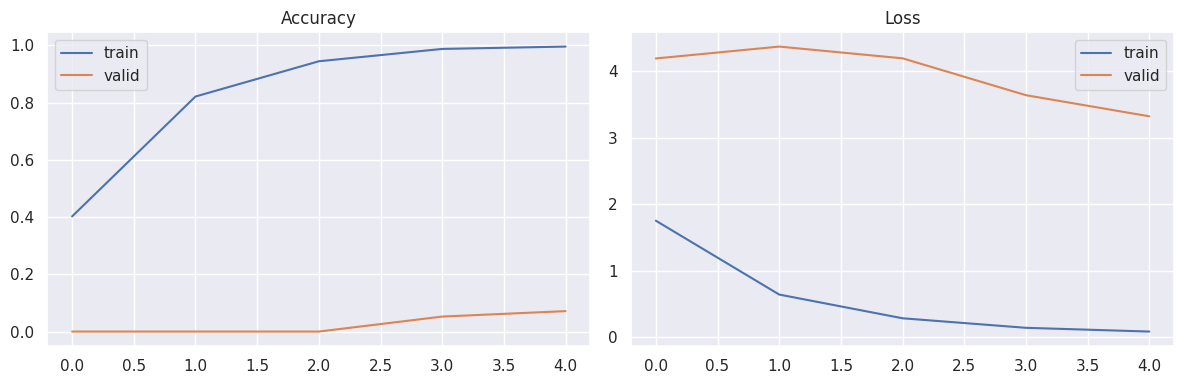

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_acc(history_obj):
    # Handle both dict and History object
    if hasattr(history_obj, 'history'):
        history_dict = history_obj.history
    else:
        history_dict = history_obj

    sns.set()
    fig = plt.figure(0, (12, 4))

    # Plot Accuracy
    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=range(len(history_dict['accuracy'])), y=history_dict['accuracy'], label='train')
    sns.lineplot(x=range(len(history_dict['val_accuracy'])), y=history_dict['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    # Plot Loss
    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=range(len(history_dict['loss'])), y=history_dict['loss'], label='train')
    sns.lineplot(x=range(len(history_dict['val_loss'])), y=history_dict['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

plot_acc(history_mobile)


Save to this marker

In [23]:
#marker number 2, save data to current position
import os
import pickle
import json
import numpy as np

# Save directory
save_dir = '/content/drive/MyDrive/final_project/marker2'
os.makedirs(save_dir, exist_ok=True)

# Save model
model.save(os.path.join(save_dir, 'model.keras'))

# Save training history (assuming history is a dict)
with open(os.path.join(save_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

# Save dataset
np.save(os.path.join(save_dir, 'data.npy'), np.array(data))
np.save(os.path.join(save_dir, 'labels.npy'), np.array(labels))

# Save label mapping
with open(os.path.join(save_dir, 'label_map.json'), 'w') as f:
    json.dump(Str_to_Int, f)


Load the densenet marker

In [24]:
import os
import pickle
import json
import numpy as np
from keras.models import load_model

# Load directory
load_dir = '/content/drive/MyDrive/final_project/marker2'

# Load model
model = load_model(os.path.join(load_dir, 'model.keras'))

# Load training history
with open(os.path.join(load_dir, 'history.pkl'), 'rb') as f:
    history = pickle.load(f)

# Load dataset
data = np.load(os.path.join(load_dir, 'data.npy'))
labels = np.load(os.path.join(load_dir, 'labels.npy'))

# Load label mapping
with open(os.path.join(load_dir, 'label_map.json'), 'r') as f:
    Str_to_Int = json.load(f)


# **CNN**

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

def cnn():
    model=Sequential()

    model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(240,240,3)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))

    return model

In [26]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam  # Make sure this is included

model_cnn = cnn()
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 238, 238, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 236, 236, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 118, 118, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 118, 118, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 116, 116, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,561 (6.19 MB)

 Trainable params: 1,621,561 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_cnn = model_cnn.fit(
    np.array(data),
    np.array(labels),
    epochs=5,
    shuffle=True,
    validation_split=0.25
)


Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.1555 - loss: 2.1317 - val_accuracy: 0.0000e+00 - val_loss: 2.7575
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.1465 - loss: 2.0836 - val_accuracy: 0.0171 - val_loss: 2.6503
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.1672 - loss: 2.0157 - val_accuracy: 0.0000e+00 - val_loss: 2.8102
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.2203 - loss: 1.9274 - val_accuracy: 0.0000e+00 - val_loss: 2.8369
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.3032 - loss: 1.8180 - val_accuracy: 0.0000e+00 - val_loss: 2.9356


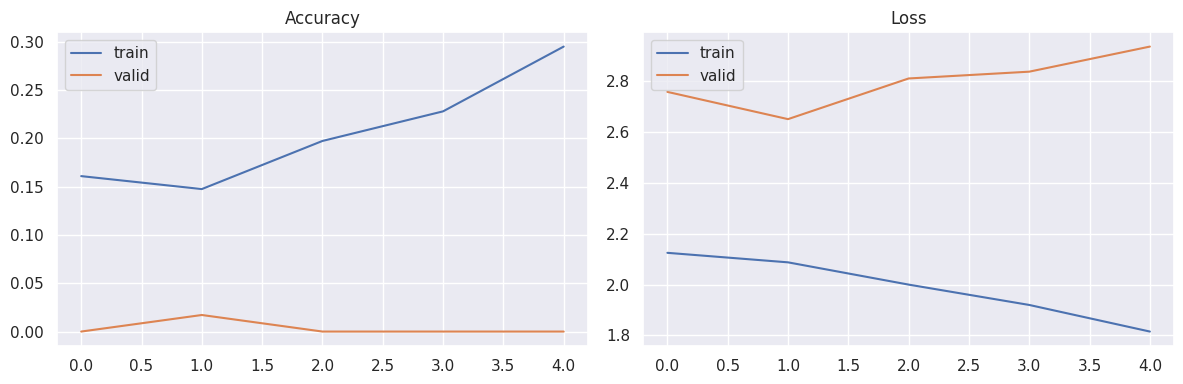

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_acc(history_obj):
    history_dict = history_obj.history  # Access the internal dictionary

    sns.set()
    fig = plt.figure(0, (12, 4))

    # Plot Accuracy
    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=range(len(history_dict['accuracy'])), y=history_dict['accuracy'], label='train')
    sns.lineplot(x=range(len(history_dict['val_accuracy'])), y=history_dict['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    # Plot Loss
    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=range(len(history_dict['loss'])), y=history_dict['loss'], label='train')
    sns.lineplot(x=range(len(history_dict['val_loss'])), y=history_dict['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

plot_acc(history_cnn)

Save Model

In [32]:
model.save('/content/drive/MyDrive/final_project/SkinDiseasePrediction.h5')


# **Evaluate Model**


In [35]:
IMG_SAVE_PATH_TESTING = '/content/drive/MyDrive/val'


In [36]:
import os
import PIL
import cv2
import numpy as np

dataset_testing = []

for directory in os.listdir(IMG_SAVE_PATH_TESTING):
    path = os.path.join(IMG_SAVE_PATH_TESTING, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        try:
            imgpath = PIL.Image.open(new_path)
            imgpath = imgpath.convert('RGB')               # Ensure 3-channel image
            img = np.asarray(imgpath)
            img = cv2.resize(img, (240, 240))              # Resize
            img = img / 255.0                              # Normalize
            dataset_testing.append([img, directory])       # Append with label
        except Exception as e:
            print(f"Error processing {new_path}: {e}")


In [37]:
# Unpack images and labels
testing_data, testing_labels = zip(*dataset_testing)

# Map string labels to integer indices
testing_temp = list(map(str_to_Int_mapper, testing_labels))


In [38]:
import keras
testing_labels = keras.utils.to_categorical(testing_temp)


In [39]:
model.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.4238 - loss: 1.7528


[1.5024324655532837, 0.5138121843338013]

In [40]:
model_mobile.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3690 - loss: 2.2181


[1.8430341482162476, 0.45856353640556335]

In [41]:
from keras.utils import to_categorical
testing_labels = to_categorical(testing_temp, num_classes=9)


## Prediction

In [48]:
!pip install scipy==1.5.4
!pip install scikit-plot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 18.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step


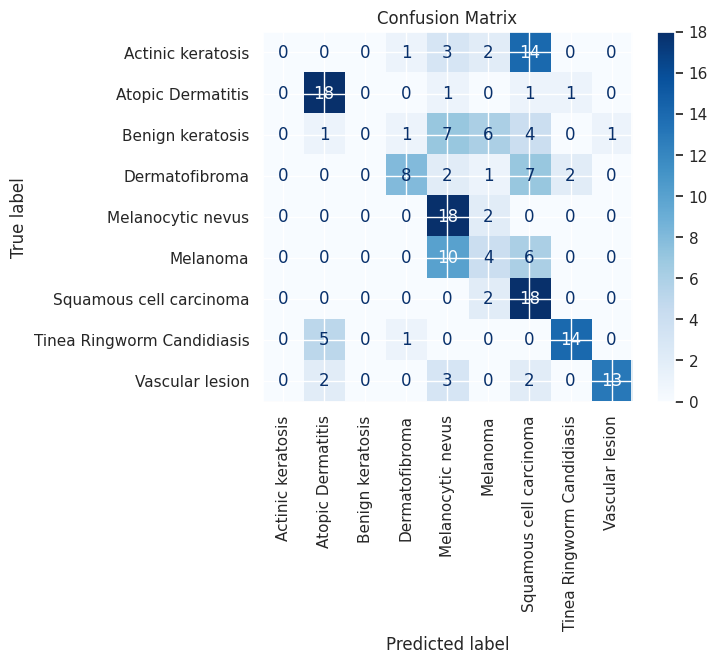

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict classes
pred_probs = model.predict(np.array(testing_data))
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(testing_labels, axis=1)

cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(Str_to_Int.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [56]:
def make_preds(model, data):
    preds_probs = model.predict(np.array(data))
    preds = np.argmax(preds_probs, axis=1)
    return preds


In [57]:
pred_labels_densenet = make_preds(model, testing_data)
pred_labels_mobilenet = make_preds(model_mobile, testing_data)
pred_labels_cnn = make_preds(model_cnn, testing_data)


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step


In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, pred_labels, label_map, title):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


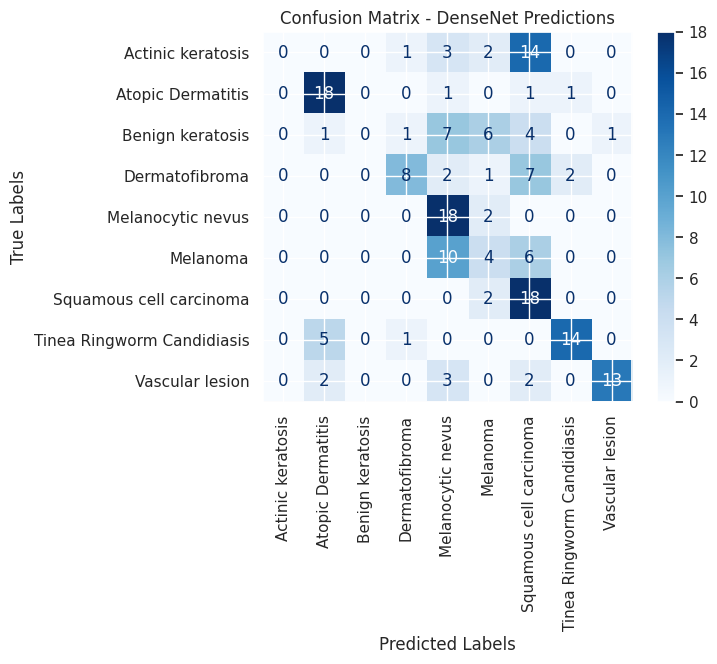

In [62]:
true_class_labels = np.argmax(testing_labels, axis=1)

plot_confusion_matrix(true_class_labels, pred_labels_densenet, Str_to_Int, "Confusion Matrix - DenseNet Predictions")



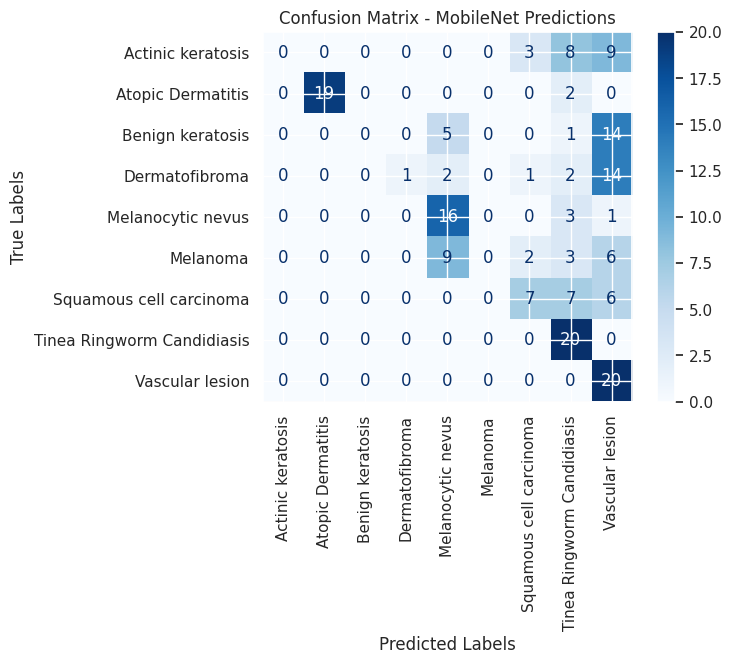

In [63]:
plot_confusion_matrix(true_class_labels, pred_labels_mobilenet, Str_to_Int, "Confusion Matrix - MobileNet Predictions")

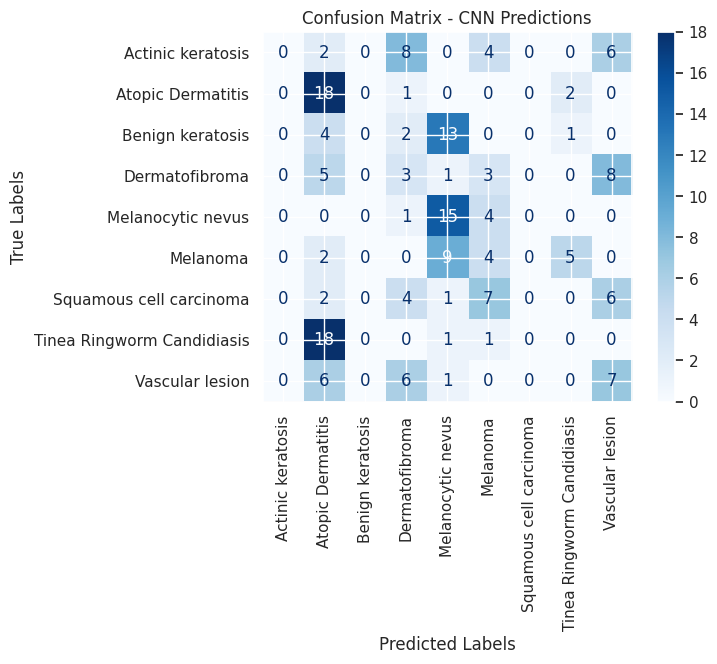

In [64]:
plot_confusion_matrix(true_class_labels, pred_labels_cnn, Str_to_Int, "Confusion Matrix - CNN Predictions")